In [1]:
cd AdversarialRendering/

/home/dcor/niskhizov/AdversarialRendering


In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
from peft import LoraConfig, get_peft_model


In [3]:
import sys

In [4]:
sys.path.append('/home/dcor/niskhizov/dinov2')

In [5]:
from dinov2.models.vision_transformer import vit_small

/home/dcor/niskhizov/dinov2/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/dcor/niskhizov/dinov2/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/dcor/niskhizov/dinov2/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [6]:
import torchvision
resizer = torchvision.transforms.Resize((224, 448))
unresizer = torchvision.transforms.Resize((480, 640))

In [7]:
unet = models.segmentation.deeplabv3_resnet50(pretrained=True)

/home/dcor/niskhizov/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dcor/niskhizov/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
unet.classifier[4] = nn.Conv2d(256, 3, kernel_size=1)

In [9]:
unet.backbone.conv1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [10]:
# unet.backbone.layer4

In [11]:
# config = LoraConfig(
#     r=8,  # Low-rank parameter
#     lora_alpha=16,
#     lora_dropout=0.05,
#     target_modules=["conv1"]  # Apply LoRA to deeper layers
# )

# unet = get_peft_model(unet, config)

In [12]:
dinov2_vitbs14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14").cuda()

Using cache found in /home/dcor/niskhizov/cache/hub/facebookresearch_dinov2_main


In [13]:
# with torch.no_grad():
#     o = dinov2_vitbs14.forward_features(resizer(anchor.cuda()))

In [14]:
# Load DINOv2-Small (ViT-S/14)
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
dinov2_vits14.eval()  # Set to evaluation mode (no training)

class DINOv2Img2Img(nn.Module):
    def __init__(self, num_output_channels=3):
        super(DINOv2Img2Img, self).__init__()

        self.backbone = dinov2_vits14  # Pretrained DINOv2 model (frozen)
        
        # Decoder: Converts DINOv2 features into an image
        self.decoder = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),  # DINOv2-S output has 384 channels
            nn.ReLU(),
            nn.Conv2d(256, num_output_channels, kernel_size=1),
            nn.Sigmoid()  # Ensures output is in range 0-1
        )

    def forward(self, x):
        x_tmp = resizer(x)
        with torch.no_grad():  # Don't train DINOv2 backbone
            features = self.backbone.forward_features(x_tmp)  # Extract high-level features
            features = features["x_norm_patchtokens"]  # Use normalized patch tokens
            # print(features.shape)
            features = features.permute(0, 2, 1).view(x_tmp.shape[0], 384, 32, 16)  # Reshape

        output = self.decoder(features)  # Convert features to image
        # print(output.shape)
        output = nn.functional.interpolate(output, size=(512, 512), mode="bilinear", align_corners=False)  # Upsample
        return x + unresizer(output)  # Output image in range [0,1]

model = DINOv2Img2Img().cuda()

Using cache found in /home/dcor/niskhizov/cache/hub/facebookresearch_dinov2_main


In [15]:
import glob
import tqdm
import matplotlib.pyplot as plt
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [16]:
projections_dir = '/home/dcor/niskhizov/projections_pairs/projections_patch8/'
patterns_dir = "/home/dcor/niskhizov/projections_pairs/rnd_patterns_patch5/"
projections = glob.glob(projections_dir + '/*')
patterns = glob.glob(patterns_dir + '/*')
# load data from calibration
import pickle
with open('/home/dcor/niskhizov/AdversarialRendering//calibration_dump/calibration3.pickle','rb') as f:
    H = pickle.load(f)
with open('/home/dcor/niskhizov/AdversarialRendering//calibration_dump/orig_ref_frame3.pickle','rb') as f:
# with open('/home/dcor/niskhizov/AdversarialRendering//calibration_dump/orig_ref_frame2.pickle','rb') as f:
    orig_ref_frame = pickle.load(f)

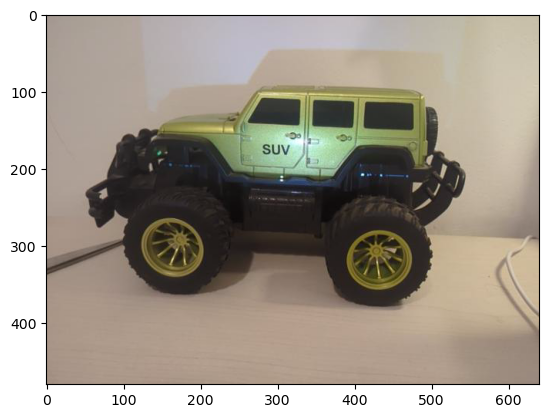

In [17]:
plt.imshow(orig_ref_frame)

In [18]:
from torchvision import transforms

tt = transforms.ToTensor()

import torch 
import kornia
H_t = torch.tensor(H).float().unsqueeze(0)
def warp(img):
    return kornia.geometry.transform.warp_perspective(img, H_t, (orig_ref_frame.shape[0], orig_ref_frame.shape[1]))

In [19]:
orig_ref_frame_tensor = tt(orig_ref_frame).unsqueeze(0)


In [20]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

tp = transforms.ToPILImage()
tt = transforms.ToTensor()

# 300 600 resize



class ImagePairDataset(Dataset):
    def __init__(self, projections, patterns, transform=None):
        self.projections = projections
        self.patterns = patterns

    def __len__(self):
        return len(self.projections)

    def __getitem__(self, idx):
       
        proj_path = self.projections[idx]

        proj_image = cv2.imread(proj_path)

        proj_image = cv2.cvtColor(proj_image, cv2.COLOR_BGR2RGB)

        proj_pattern = proj_image#[185:235,284:384,:]#[150:250,180:380,:]

        pattern_path = self.patterns[idx]

        pattern = cv2.imread(pattern_path)#.transpose(1, 0, 2)

        proj_pattern = tt(proj_pattern)
        pattern = tt(pattern).unsqueeze(0)


        imag_w = warp(pattern)
        mask_w = warp(pattern*0+1)

        sum_tensor =  ((mask_w != 0) * -0.5 + 1) * orig_ref_frame_tensor + imag_w * 0.5

        sum_tensor = sum_tensor[0]
        

        return sum_tensor, proj_pattern 


dataset = ImagePairDataset(projections, patterns)

In [21]:
train_size = int(0.8 * len(projections))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=8 )

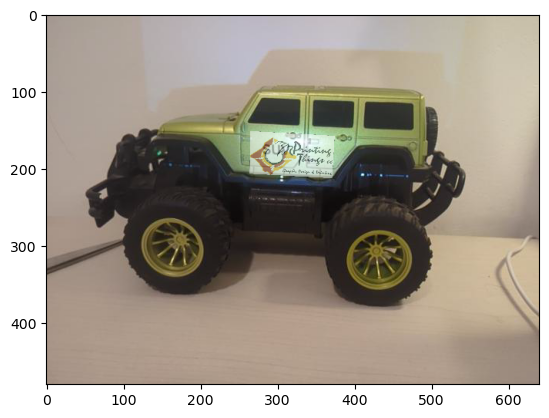

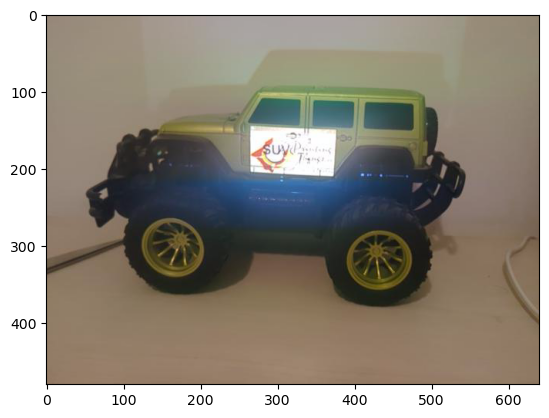

In [22]:
idx = 100
plt.imshow(dataset[idx][0].permute(1, 2, 0))
plt.show()
plt.imshow(dataset[idx][1].permute(1, 2, 0))
plt.show()

In [23]:
import tqdm

In [24]:
model.load_state_dict(torch.load('lora_dyno.pth'))

/tmp/ipykernel_750500/3948406256.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('lora_dyno.pth'))


<All keys matched successfully>

0it [00:00, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.3926222e-16..1.2071362].


Epoch 1, Loss: 0.0442


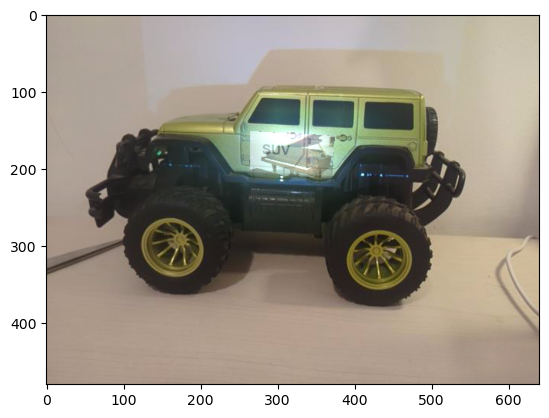

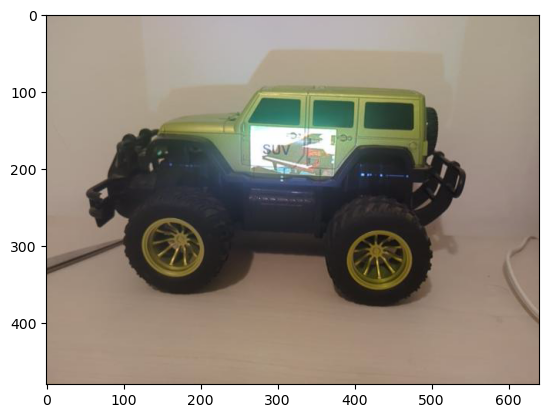

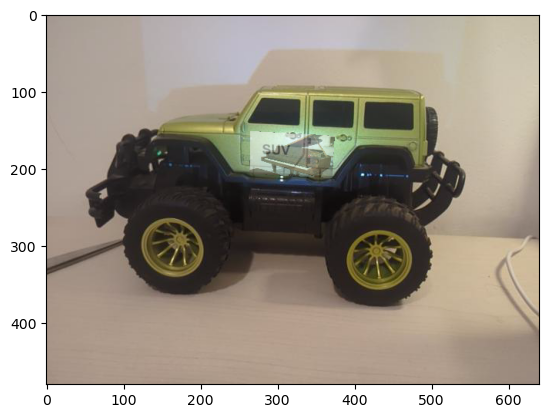

37it [00:52,  1.42s/it]


KeyboardInterrupt: 

In [25]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for epoch in range(100):
    for idx,(anchor, target) in tqdm.tqdm(enumerate(train_dataloader)):  # Load (anchor image, modified target)
        anchor, target = anchor.cuda(), target.cuda()
        
        optimizer.zero_grad()
        pred = model(anchor)
        
        loss = nn.L1Loss()(pred, target)  # Use L1 loss since most pixels remain unchanged
        loss.backward()
        optimizer.step()

        if idx % 100 == 0:
    
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
            plt.imshow(pred[0].detach().cpu().numpy().transpose(1, 2, 0))
            plt.show()
            plt.imshow(target[0].detach().cpu().numpy().transpose(1, 2, 0))
            plt.show()
            plt.imshow(anchor[0].detach().cpu().numpy().transpose(1, 2, 0))
            plt.show()
            


In [29]:
# save anchor to pikle
import pickle
with open('anchor.pickle','wb') as f:
    pickle.dump(anchor.cpu(), f)
# save target to pikle
import pickle
with open('target.pickle','wb') as f:
    pickle.dump(target.cpu(), f)

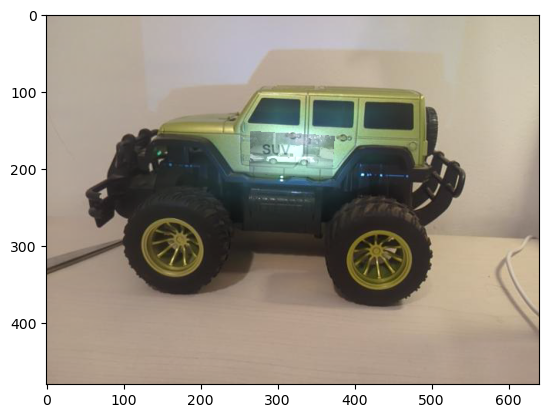

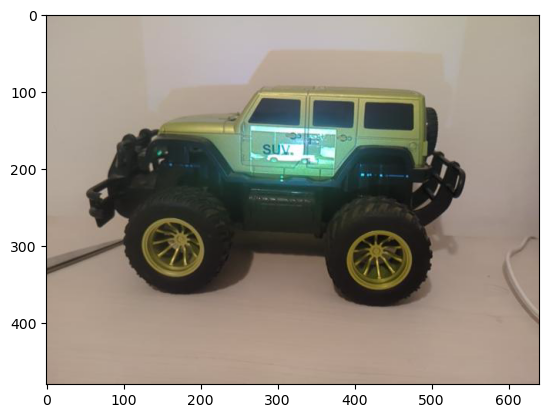

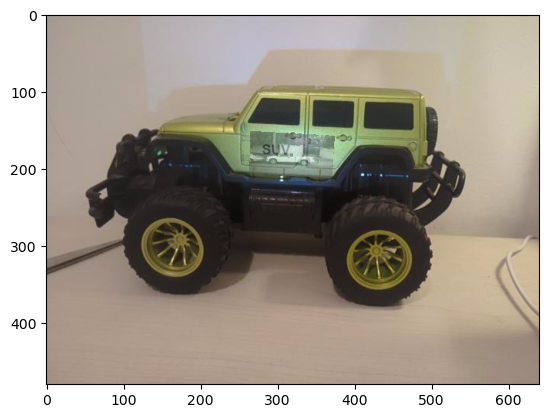

In [31]:
import pickle
with open('anchor.pickle','rb') as f:
    anchor = pickle.load(f)

with open('target.pickle','rb') as f:
    target = pickle.load(f)
model.eval        
with torch.no_grad():
    pred = model(anchor.cuda())
plt.imshow(pred[0].detach().cpu().numpy().transpose(1, 2, 0))
plt.show()
plt.imshow(target[0].detach().cpu().numpy().transpose(1, 2, 0))
plt.show()
plt.imshow(anchor[0].detach().cpu().numpy().transpose(1, 2, 0))
plt.show()

In [ ]:
# save the model
torch.save(model.state_dict(), 'lora_dyno.pth')

In [ ]:
pwd

In [ ]:
pred = model(anchor)

In [ ]:
anchor.shape

In [ ]:
plt.imshow(anchor[0].detach().cpu().numpy().transpose(1, 2, 0))